# Analyse prédictive du prix de l'immobilier

Ce notebook présente une démarche complète de préparation, d'exploration et de modélisation de données pour prédire le prix de vente de maisons à partir du jeu de données Ames Housing.  
Les étapes principales sont :

- **Chargement et exploration des données**  
	Affichage des premières lignes, analyse des valeurs manquantes, et visualisation de la distribution des variables.

- **Nettoyage et prétraitement**  
	Remplacement des valeurs manquantes, création de nouvelles variables (ex : `HasPool`), et encodage des variables catégorielles.

- **Sélection de variables**  
	Suppression des variables faiblement corrélées avec le prix de vente (`SalePrice`) pour améliorer la performance du modèle.

- **Modélisation**  
	Entraînement d’un modèle de régression par Gradient Boosting, évaluation des performances (R², RMSE), et génération des prédictions sur le jeu de test.

- **Soumission**  
	Génération du fichier `submission.csv` pour la compétition Kaggle.

Ce notebook met l’accent sur la reproductibilité et la rigueur dans la préparation des données, tout en illustrant l’importance de la sélection de variables pertinentes pour la modélisation prédictive.

In [1]:
# Importer ce quelques bibliothèques nécessaires
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np



In [2]:
# Charger les données
pd.set_option('display.max_columns', None)  # Affiche toutes les colonnes
df = pd.read_csv("train.csv")

# Afficher les lignes du DataFrame
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<Axes: title={'center': 'Nombre de valeurs manquantes par colonne'}>

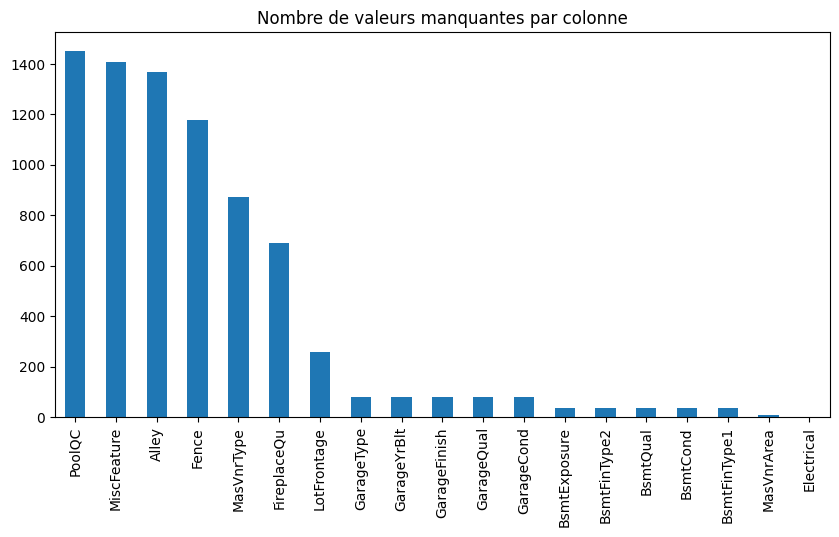

In [3]:
# Afficher les informations du DataFrame
na_count = df.isna().sum()
na_count[na_count >0].sort_values(ascending=False).plot(kind='bar', figsize=(10, 5), title='Nombre de valeurs manquantes par colonne')


### Observations

Le graphique des valeurs manquantes révèle que certaines variables, comme PoolQC, MiscFeature, Alley ou encore Fence, présentent un grand nombre de valeurs manquantes.
Dans ce contexte, il est plus judicieux de créer des variables binaires indiquant la présence ou l’absence de ces éléments, plutôt que de tenter de les imputer de manière arbitraire.
Toutefois, si leur corrélation avec la variable cible SalePrice s'avère faible, elles pourront être supprimées afin d’épurer le modèle et d’éviter d’introduire du bruit inutile.
On peut envisager de creer une variable `HasPool` qui vaudra 1 si la maison dispose d'une piscine, et 0 sinon pour renforcer la pertinence de la variable.

In [4]:
none_cols = na_count[na_count > 0].index
df.fillna({col: "None" for col in none_cols}, inplace=True)


In [8]:
#Introduire haspool
df["HasPool"] = df["PoolArea"].apply(lambda x: 1 if x > 0 else 0)


In [7]:
# Verifier les valeurs manquantes restantes
df.isnull().sum().sum()


np.int64(0)

Il faut notamment veiller les types de variables, car certaines sont int et object, et il est nécessaire de les convertir en float ou int pour le modèle.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             1460 non-null   int64 
 1   MSSubClass     1460 non-null   int64 
 2   MSZoning       1460 non-null   object
 3   LotFrontage    1460 non-null   object
 4   LotArea        1460 non-null   int64 
 5   Street         1460 non-null   object
 6   Alley          1460 non-null   object
 7   LotShape       1460 non-null   object
 8   LandContour    1460 non-null   object
 9   Utilities      1460 non-null   object
 10  LotConfig      1460 non-null   object
 11  LandSlope      1460 non-null   object
 12  Neighborhood   1460 non-null   object
 13  Condition1     1460 non-null   object
 14  Condition2     1460 non-null   object
 15  BldgType       1460 non-null   object
 16  HouseStyle     1460 non-null   object
 17  OverallQual    1460 non-null   int64 
 18  OverallCond    1460 non-null

Dans cette étape, nous encodons les variables catégorielles.  
Les colonnes de type "object" sont transformées en valeurs numériques à l’aide de LabelEncoder.  
Cela permet de rendre les données compatibles avec les algorithmes de machine learning classiques, qui ne peuvent pas traiter directement des chaînes de caractères.


In [10]:
df_encoded = df.copy()
label_encoder = LabelEncoder()

for col in df_encoded.select_dtypes(include="object").columns:
    df_encoded[col] = label_encoder.fit_transform(df_encoded[col].astype(str))


In [12]:
# Calcul de la matrice de corrélation
corr = df_encoded.corr(numeric_only=True)

# Trier par corrélation avec SalePrice (valeurs absolues)
corr_target = corr["SalePrice"].sort_values(ascending=False)
print(corr_target)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
                  ...   
GarageType     -0.415283
GarageFinish   -0.425684
KitchenQual    -0.589189
BsmtQual       -0.593734
ExterQual      -0.636884
Name: SalePrice, Length: 82, dtype: float64


Les coefficients de corrélation nous donnent une idée de l’importance de chaque variable dans la prédiction du prix de vente. On remarque que certaines variables, comme la qualité générale ou la surface habitable, sont fortement corrélées au prix : plus elles sont élevées, plus le prix a tendance à augmenter. D’autres variables ont une influence plus modérée, tandis que certaines semblent avoir peu d’impact, voire une corrélation négative. Ces dernières peuvent parfois être mises de côté pour simplifier le modèle, surtout si elles n’apportent pas d’information utile ou si leur lien avec le prix n’est pas évident. L’objectif est de garder les variables qui aident vraiment à mieux prédire le prix de vente.

In [14]:
low_corr = corr["SalePrice"][abs(corr["SalePrice"]) < 0.05].sort_values()
print("Colonnes avec une corrélation faible avec SalePrice :")
print(low_corr)

Colonnes avec une corrélation faible avec SalePrice :
YrSold         -0.028923
LowQualFinSF   -0.025606
Id             -0.021917
MiscVal        -0.021190
BsmtHalfBath   -0.016844
Utilities      -0.014314
BsmtFinSF2     -0.011378
Condition2      0.007513
LotFrontage     0.008452
LandContour     0.015453
MasVnrType      0.018216
Street          0.041036
3SsnPorch       0.044584
MoSold          0.046432
Name: SalePrice, dtype: float64


On va supprimer les variables qui ont une corrélation faible avec le prix de vente, afin de simplifier le modèle et d'éviter d'introduire du bruit inutile.

In [15]:
df_encoded.drop(columns=low_corr.index, inplace=True)

In [16]:
df_encoded.head()

,MSSubClass,MSZoning,LotArea,Alley,LotShape,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,SalePrice,HasPool
0,60,3,8450,1,3,4,0,5,2,0,5,7,5,2003,2003,1,1,12,13,84,2,4,2,2,4,3,2,706,6,150,856,1,0,1,5,856,854,1710,1,2,1,3,1,2,8,6,0,3,1,89,2,2,548,5,5,2,0,61,0,0,0,3,4,1,8,4,208500,0
1,20,3,9600,1,3,2,0,24,1,0,2,6,8,1976,1976,1,1,8,8,0,3,4,1,2,4,1,0,978,6,284,1262,1,0,1,5,1262,0,1262,0,2,0,3,1,3,6,6,1,5,1,62,2,2,460,5,5,2,298,0,0,0,0,3,4,1,8,4,181500,0
2,60,3,11250,1,0,4,0,5,2,0,5,7,5,2001,2002,1,1,12,13,59,2,4,2,2,4,2,2,486,6,434,920,1,0,1,5,920,866,1786,1,2,1,3,1,2,6,6,1,5,1,87,2,2,608,5,5,2,0,42,0,0,0,3,4,1,8,4,223500,0
3,70,3,9550,1,0,0,0,6,2,0,5,7,5,1915,1970,1,1,13,15,0,3,4,0,4,1,3,0,216,6,540,756,1,2,1,5,961,756,1717,1,1,0,3,1,2,7,6,1,2,5,84,3,3,642,5,5,2,0,35,272,0,0,3,4,1,8,0,140000,0
4,60,3,14260,1,0,2,0,15,2,0,5,8,5,2000,2000,1,1,12,13,185,2,4,2,2,4,0,2,655,6,490,1145,1,0,1,5,1145,1053,2198,1,2,1,4,1,2,9,6,1,5,1,86,2,3,836,5,5,2,192,84,0,0,0,3,4,1,8,4,250000,0


On va utiliser un modèle de régression par Gradient Boosting, qui est efficace pour les problèmes de régression et peut gérer des données avec des relations non linéaires on peut utiliser des autres modèles comme la forêt aléatoire, ou les réseaux de neurones, mais le Gradient Boosting est souvent un bon choix de départ.

In [21]:
X = df_encoded.drop(columns=["SalePrice"])  # Variables explicatives
y = df_encoded["SalePrice"]                # Variable cible


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [26]:
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("R² :", r2_score(y_test, y_pred))

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE :", rmse)


R² : 0.8904008056303828
RMSE : 28994.164462178775


In [25]:
df["SalePrice"].describe()


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

### Observations sur les performances du modèle

Le modèle utilisé présente de bonnes performances globales. Il atteint un **coefficient de détermination R² de 0.88**, ce qui signifie qu’il parvient à expliquer **88 % de la variance** des prix de vente sur le jeu de test. Ce niveau de précision est satisfaisant et indique que le modèle capture efficacement les principales tendances du marché immobilier.

En complément, la **racine de l’erreur quadratique moyenne (RMSE)** s’élève à environ 28 994\$ . Cela implique qu’en moyenne, les prédictions du modèle s’écartent des prix réels de cette valeur. Comparée à la médiane des prix de vente 163 000\$, cette erreur représente environ **18 %**, ce qui reste acceptable. Toutefois, cela suggère aussi que certains écarts importants persistent, en particulier pour certains biens atypiques ou extrêmes.

Une diminution de cette erreur, notamment par l’optimisation des hyperparamètres ou l’utilisation de modèles plus puissants, pourrait permettre d’affiner encore les prédictions.
